## 知识蒸馏-RFID Transformer teacher->GRU student

In [1]:
import copy
import torch
import math
import numpy as np
import pandas as pd
import geatpy as ea
from tqdm import tqdm
from multiprocessing.dummy import Pool as ThreadPool
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils.calculate_param as cp
from dataset import data_read
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

### 硬件设备准备

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 加载数据集

In [3]:
X_train, y_train = data_read.load_data('train')
X_test, y_test = data_read.load_data('test')

X_train.shape

(2000, 50)

In [4]:
X_train = torch.from_numpy(X_train).float().to(device) # [len * feature]
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device) # [len * feature]
y_test = torch.from_numpy(y_test).float().to(device)

X_train.shape


torch.Size([2000, 50])

In [5]:
train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=100, shuffle=False)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=100, shuffle=False)

### 定义教师模型-transformer模型

In [6]:
# 位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        out = x + self.pe[:x.size(0), :]
        return out


class TeacherTransformer(nn.Module):
    def __init__(self):
        super(TeacherTransformer, self).__init__()
        self.d_model = 128  # 词向量维度
        self.embedding_enc = nn.Linear(50, self.d_model)
        self.embedding_dec = nn.Linear(2, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        self.Transformer_layer = nn.Transformer(d_model=128, num_encoder_layers=3, num_decoder_layers=3, batch_first=True)
        self.FC_layer = nn.Linear(128, 2)

    def forward(self, src, tgt):
        # 使用线性层代替embedding
        src = self.embedding_enc(src).unsqueeze(0)
        tgt = self.embedding_dec(tgt).unsqueeze(0)
        src = self.pos_encoding(src)
        out = self.Transformer_layer(src, tgt)
        out = self.FC_layer(out)
        return out



### 教师模型设置

In [7]:
model = TeacherTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

### 教师模型信息

In [8]:
# 输出教师模型的参数信息-300w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                                                 Param #
TeacherTransformer                                                     --
├─Linear: 1-1                                                          6,528
├─Linear: 1-2                                                          384
├─PositionalEncoding: 1-3                                              --
├─Transformer: 1-4                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            1,779,072
│    │    └─LayerNorm: 3-2                                             256
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            1,977,984
│    │    └─LayerNorm: 3-4                                             256
├─Linear: 1-5                                                          2

### 教师模型训练

In [9]:
%%time

best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:  # enc_inputs : [len * feature]->[2000 * 50]
        # print(X.shape)  # [100 * 50]
        # print(y.shape)  # [100 * 50]
        outputs = model(X, y)
        outputs = outputs.squeeze()  # [100 * 2]
        # print(outputs.shape)
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/teacher_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 146.021196
Epoch: 0002 loss = 48.642279
Epoch: 0003 loss = 48.374830
Epoch: 0004 loss = 40.773885
Epoch: 0005 loss = 38.780626
Epoch: 0006 loss = 31.814842
Epoch: 0007 loss = 22.182482
Epoch: 0008 loss = 15.505138
Epoch: 0009 loss = 13.970082
Epoch: 0010 loss = 9.494105
Epoch: 0011 loss = 5.759591
Epoch: 0012 loss = 5.455363
Epoch: 0013 loss = 4.145405
Epoch: 0014 loss = 4.251118
Epoch: 0015 loss = 3.749619
Epoch: 0016 loss = 2.698970
Epoch: 0017 loss = 2.341664
Epoch: 0018 loss = 2.750972
Epoch: 0019 loss = 2.069706
Epoch: 0020 loss = 2.142641
Epoch: 0021 loss = 1.876754
Epoch: 0022 loss = 1.554499
Epoch: 0023 loss = 1.750292
Epoch: 0024 loss = 1.905683
Epoch: 0025 loss = 1.418602
Epoch: 0026 loss = 1.549186
Epoch: 0027 loss = 1.689632
Epoch: 0028 loss = 1.545023
Epoch: 0029 loss = 1.254578
Epoch: 0030 loss = 1.295816
Epoch: 0031 loss = 1.113830
Epoch: 0032 loss = 1.197965
Epoch: 0033 loss = 1.369943
Epoch: 0034 loss = 1.013569
Epoch: 0035 loss = 1.231339
Epoch: 003

### 教师模型评估

In [10]:
model = TeacherTransformer().to(device)
# 暂存教师模型为teacher_model
teacher_model = model
model.load_state_dict(torch.load('./result/teacher_weight.pth'))
model.eval()
pxy = model(X_test, y_test)
pxy = pxy.cpu().detach().numpy().squeeze(0)
y_test = y_test.cpu().detach().numpy()

# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

{'mae': 0.084892, 'mse': 0.011776982, 'rmse': 0.10852180368617363, 'evs': 0.9972739815711975, 'r2': 0.9943189869485213, 'mmax': 0.21287823, 'mmin': 0.0052908137}


### 教师模型定位效果可视化

In [11]:
y_teacher = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_teacher)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_teacher.csv')
coor

,X,y,PX,Py
0,0.21,3.47,0.179203,3.613626
1,1.13,1.96,1.182119,2.018872
2,3.38,2.58,3.475395,2.628522
3,4.07,2.72,4.254373,2.789131
4,1.58,2.47,1.662742,2.512204
5,3.43,1.61,3.558935,1.657329
6,1.22,0.74,1.247052,0.733851
7,2.33,1.97,2.385608,2.029962
8,0.33,3.56,0.297978,3.725786
9,3.53,4.28,3.700464,4.499172


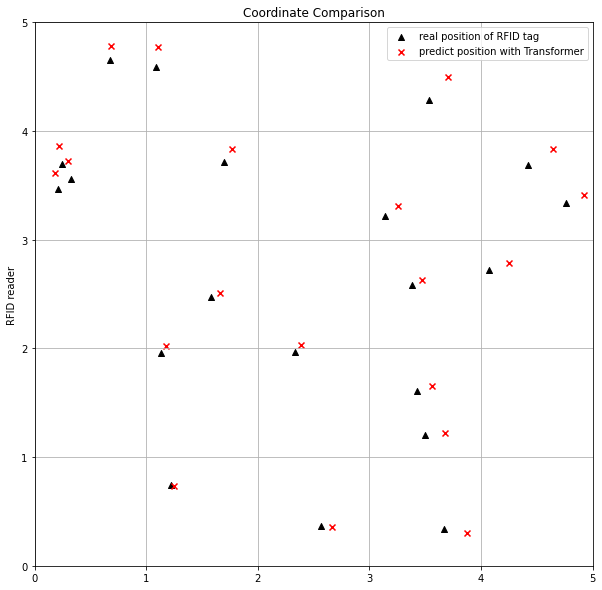

In [12]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 5))
plt.ylim((0, 5))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_teacher[:, 0], y_teacher[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with Transformer')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_teacher.jpg', dpi=750, bbox_inches = 'tight')

### 定义学生模型-小变压器模型

In [13]:
class StudentTransformer(nn.Module):
    def __init__(self):
        super(StudentTransformer, self).__init__()
        self.d_model = 8  # 词向量维度
        self.embedding_enc = nn.Linear(50, self.d_model)
        self.embedding_dec = nn.Linear(2, self.d_model)
        self.Transformer_layer = nn.Transformer(d_model=8, num_encoder_layers=1, num_decoder_layers=1, batch_first=True)
        self.FC_layer = nn.Linear(8, 2)

    def forward(self, src, tgt):
        # 使用线性层代替embedding
        src = self.embedding_enc(src).unsqueeze(0)
        tgt = self.embedding_dec(tgt).unsqueeze(0)
        out = self.Transformer_layer(src, tgt)
        out = self.FC_layer(out)
        return out

### 学生模型设置

In [14]:
# 从头先训练一下学生模型
model = StudentTransformer().to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

### 学生模型信息

In [15]:
# 输出学生模型的参数信息-1w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                                                 Param #
StudentTransformer                                                     --
├─Linear: 1-1                                                          408
├─Linear: 1-2                                                          24
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            35,144
│    │    └─LayerNorm: 3-2                                             16
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            35,448
│    │    └─LayerNorm: 3-4                                             16
├─Linear: 1-4                                                          18
Total params: 71,074
Trainable params: 71,074
Non-trainable params: 0


### 学生模型训练

In [16]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:  # enc_inputs : [len * feature]->[2000 * 50]
        outputs = model(X, y)
        outputs = outputs.squeeze()  # [100 * 2]
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/student_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|', best_loss, '---best_epoch::|', best_epoch)


Epoch: 0001 loss = 139.130597
Epoch: 0002 loss = 97.224904
Epoch: 0003 loss = 61.542907
Epoch: 0004 loss = 43.566233
Epoch: 0005 loss = 46.203680
Epoch: 0006 loss = 46.952348
Epoch: 0007 loss = 41.023726
Epoch: 0008 loss = 45.715397
Epoch: 0009 loss = 40.270610
Epoch: 0010 loss = 39.936496
Epoch: 0011 loss = 37.431767
Epoch: 0012 loss = 33.447421
Epoch: 0013 loss = 29.424758
Epoch: 0014 loss = 23.759452
Epoch: 0015 loss = 25.533319
Epoch: 0016 loss = 24.320489
Epoch: 0017 loss = 21.061591
Epoch: 0018 loss = 19.128983
Epoch: 0019 loss = 14.962416
Epoch: 0020 loss = 9.974117
Epoch: 0021 loss = 7.762563
Epoch: 0022 loss = 7.252261
Epoch: 0023 loss = 6.549025
Epoch: 0024 loss = 5.996923
Epoch: 0025 loss = 5.540876
Epoch: 0026 loss = 5.039779
Epoch: 0027 loss = 4.265544
Epoch: 0028 loss = 4.093740
Epoch: 0029 loss = 3.506531
Epoch: 0030 loss = 3.136931
Epoch: 0031 loss = 2.851424
Epoch: 0032 loss = 2.618742
Epoch: 0033 loss = 2.439405
Epoch: 0034 loss = 2.309009
Epoch: 0035 loss = 2.148235


### 学生模型评估

In [17]:
model = StudentTransformer().to(device)
# 暂存教师模型为teacher_model
student_model = model
model.load_state_dict(torch.load('./result/student_weight.pth'))
model.eval()
y_test = torch.from_numpy(y_test)
pxy = model(X_test, y_test)
pxy = pxy.cpu().detach().numpy().squeeze(0)
y_test = y_test.cpu().detach().numpy()

# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

{'mae': 0.06455692, 'mse': 0.007047292, 'rmse': 0.08394814974186886, 'evs': 0.9978922605514526, 'r2': 0.9966219557245699, 'mmax': 0.15922213, 'mmin': 0.0050887465}


### 学生模型定位效果可视化

In [13]:
y_student = y_test[:20]
pxy1 = [
[0.241, 3.488],
[1.227, 2.030],
[3.537, 2.669],
[4.336, 2.836],
[1.702, 2.534],
[3.593, 1.676],
[1.302, 0.763],
[2.442, 2.057],
[0.359, 3.796],
[3.826, 4.540],
[4.767, 3.884],
[3.932, 0.335], 
[2.717, 0.386], 
[3.319, 3.338], 
[4.935, 3.454],
[1.840, 3.895], 
[3.716, 1.242],
[0.768, 4.860], 
[1.192, 4.845], 
[0.286, 3.939] 
]
pxy1 = np.array(pxy1)
pxy2 = [
[0.192, 3.548],
[1.173, 1.972],
[3.404, 2.599],
[4.172, 2.768],
[1.621, 2.455],
[3.477, 1.648],
[1.227, 0.751],
[2.356, 1.999],
[0.304, 3.654],
[3.646, 4.429],
[4.583, 3.804],
[3.762, 0.336], 
[2.599, 0.389],
[3.171, 3.239], 
[4.869, 3.397], 
[1.750, 3.755], 
[3.587, 1.226], 
[0.659, 4.707], 
[1.069, 4.689], 
[0.229, 3.794]]
pxy2 = np.array(pxy2)

coor1 = pd.DataFrame(y_student)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy1)
coor2.columns = ['PX-MOEA', 'Py-MOEA']

coor3 = pd.DataFrame(pxy2)
coor3.columns = ['PX-NAAS', 'Py-NAAS']

coor = pd.concat([coor1, coor2, coor3], axis=1)
coor.to_csv('./result/coordinate_all_student.csv')
coor

,X,y,PX-MOEA,Py-MOEA,PX-NAAS,Py-NAAS
0,tensor(0.2100),tensor(3.4700),0.241,3.488,0.192,3.548
1,tensor(1.1300),tensor(1.9600),1.227,2.030,1.173,1.972
2,tensor(3.3800),tensor(2.5800),3.537,2.669,3.404,2.599
3,tensor(4.0700),tensor(2.7200),4.336,2.836,4.172,2.768
4,tensor(1.5800),tensor(2.4700),1.702,2.534,1.621,2.455
5,tensor(3.4300),tensor(1.6100),3.593,1.676,3.477,1.648
6,tensor(1.2200),tensor(0.7400),1.302,0.763,1.227,0.751
7,tensor(2.3300),tensor(1.9700),2.442,2.057,2.356,1.999
8,tensor(0.3300),tensor(3.5600),0.359,3.796,0.304,3.654
9,tensor(3.5300),tensor(4.2800),3.826,4.540,3.646,4.429


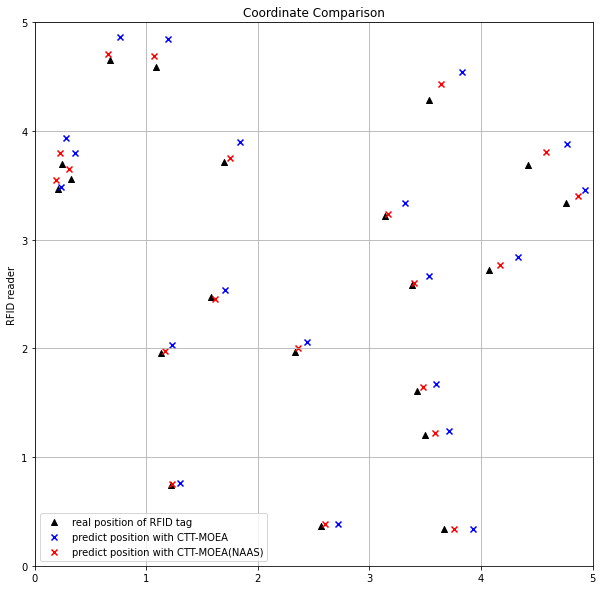

In [14]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 5))
plt.ylim((0, 5))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_student[:, 0], y_student[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy1[:, 0], pxy1[:, 1], c='blue', marker='x', label = 'predict position with CTT-MOEA')

# 画图-预测EA坐标
plt.scatter(pxy2[:, 0], pxy2[:, 1], c='red', marker='x', label = 'predict position with CTT-MOEA(NAAS)')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_student.jpg', dpi=750, bbox_inches = 'tight')

### 知识蒸馏准备与设置

In [45]:
# 准备预训练好的教师模型
teacher_model.eval()

# 准备新的学生模型
model = StudentTransformer().to(device)

# 蒸馏温度
T = 9

# 蒸馏参数设置
# hard_loss
hard_loss = nn.MSELoss()
# hard_loss权重
alpha = 0.3
# soft_loss kl散度
soft_loss = nn.KLDivLoss(reduction='batchmean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 知识蒸馏训练

In [46]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(50):
    epoch_loss = 0
    for X, y in train_data_loader:
        X, y = X.to(device), y.to(device)
        # 教师模型预测
        with torch.no_grad():
            teacher_outputs = teacher_model(X, y)
        # 学生模型预测
        student_outputs = model(X, y)
        student_loss = hard_loss(student_outputs, y)
        # 计算蒸馏后的预测结果及soft_loss
        distillation_loss = soft_loss(
            F.softmax(student_outputs/T, dim=1),
            F.softmax(teacher_outputs/T, dim=1)
        )
        # 将 hard_loss 和 soft_loss 加权求和
        loss = alpha * student_loss + (1-alpha) * distillation_loss * T **2
        # 反向传播,优化权重
        optimizer.zero_grad()
        epoch_loss += loss.item()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/distillation_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


/Users/frank/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100, 2])) that is different to the input size (torch.Size([1, 100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0001 loss = -10411.670044
Epoch: 0002 loss = -10418.210693
Epoch: 0003 loss = -10421.324890
Epoch: 0004 loss = -10423.941284
Epoch: 0005 loss = -10426.218933
Epoch: 0006 loss = -10428.354126
Epoch: 0007 loss = -10430.313354
Epoch: 0008 loss = -10431.782532
Epoch: 0009 loss = -10432.940125
Epoch: 0010 loss = -10433.869324
Epoch: 0011 loss = -10434.597595
Epoch: 0012 loss = -10435.117432
Epoch: 0013 loss = -10435.506226
Epoch: 0014 loss = -10435.813904
Epoch: 0015 loss = -10436.074402
Epoch: 0016 loss = -10436.317200
Epoch: 0017 loss = -10436.344788
Epoch: 0018 loss = -10436.564209
Epoch: 0019 loss = -10436.755188
Epoch: 0020 loss = -10436.831909
Epoch: 0021 loss = -10436.896179
Epoch: 0022 loss = -10437.046326
Epoch: 0023 loss = -10436.998596
Epoch: 0024 loss = -10437.144775
Epoch: 0025 loss = -10437.139221
Epoch: 0026 loss = -10437.155823
Epoch: 0027 loss = -10437.171570
Epoch: 0028 loss = -10437.223450
Epoch: 0029 loss = -10437.242004
Epoch: 0030 loss = -10437.252441
Epoch: 003

KeyboardInterrupt: 

### 蒸馏模型评估

In [47]:
model = StudentTransformer().to(device)
model.load_state_dict(torch.load('./result/distillation_weight.pth'))
model.eval()
y_test = torch.from_numpy(y_test)
pxy = model(X_test, y_test)
pxy = pxy.cpu().detach().numpy().squeeze(0)
y_test = y_test.cpu().detach().numpy()

# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

{'mae': 0.1518006, 'mse': 0.03801897, 'rmse': 0.19498454216064115, 'evs': 0.9847988784313202, 'r2': 0.9816030012417469, 'mmax': 0.71145415, 'mmin': 0.016973555}


### 蒸馏模型定位效果可视化

In [48]:
y_distill = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_distill)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_distill.csv')
coor

,X,y,PX,Py
0,0.21,3.47,0.284969,3.602425
1,1.13,1.96,1.164377,2.080438
2,3.38,2.58,3.682233,2.803676
3,4.07,2.72,4.393359,2.952392
4,1.58,2.47,1.603147,2.571705
5,3.43,1.61,3.892507,1.795763
6,1.22,0.74,1.254863,0.782649
7,2.33,1.97,2.426601,2.106437
8,0.33,3.56,0.382243,3.688406
9,3.53,4.28,3.531628,4.341705


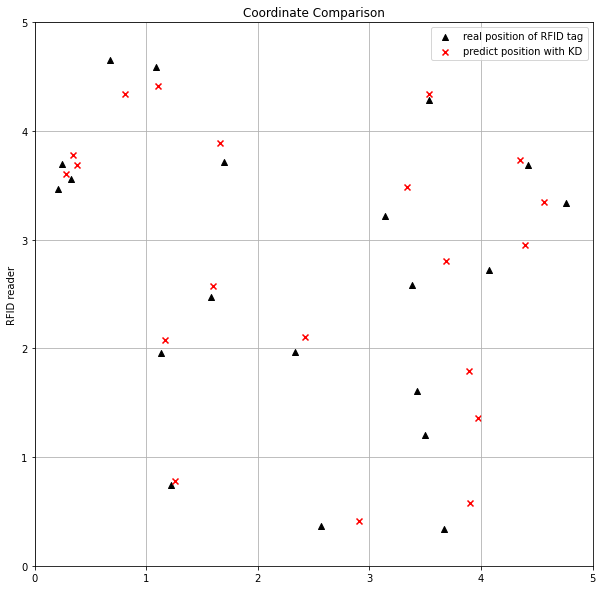

In [49]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 5))
plt.ylim((0, 5))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_distill[:, 0], y_distill[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with KD')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_distill.jpg', dpi=750, bbox_inches = 'tight')

### 定义问题类

In [19]:
class MOEA(ea.Problem):
    def __init__(self, train_data_loader, test_data_loader):
        name = 'MOEA'
        M = 1 # 初始化M（目标维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim) # 初始化varTypes 0-连续
        lb = [5, 0.1] # 决策变量下界
        ub = [10, 0.9] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader


    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        # print(Vars)
        pop.ObjV = np.zeros((pop.sizes, 1)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            epochs, alpha = int(Vars[i, 0]), float(Vars[i, 1])
            print(epochs, alpha)
            final_loss = 0
            for epoch in range(epochs):
                for data,targets in tqdm(train_data_loader):
                    data, targets = data.to(device), targets.to(device)
                    # 教师模型预测
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    # 学生模型预测
                    student_outputs = model(data)
                    student_loss = hard_loss(student_outputs, targets)
                    # 计算蒸馏后的预测结果及soft_loss
                    distillation_loss = soft_loss(
                        F.softmax(student_outputs/T, dim=1),
                        F.softmax(teacher_outputs/T, dim=1)
                    )
                    # 将 hard_loss 和 soft_loss 加权求和
                    loss = alpha * student_loss + (1-alpha) * distillation_loss
                    final_loss = loss.item()
                    # 反向传播,优化权重
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            pop.ObjV[i] = final_loss # 最小化最终的损失作为目标函数
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes))) # 散列种群每个个体进行加速计算


    # 代入优化后的参数先训练再对测试集进行检验，计算指标
    def test(self, epochs, alpha):
        for epoch in range(epochs):
            for data,targets in tqdm(train_data_loader):
                data, targets = data.to(device), targets.to(device)
                # 教师模型预测
                with torch.no_grad():
                    teacher_outputs = teacher_model(data)
                # 学生模型预测
                student_outputs = model(data)
                student_loss = hard_loss(student_outputs, targets)
                # 计算蒸馏后的预测结果及soft_loss
                distillation_loss = soft_loss(
                    F.softmax(student_outputs/T, dim=1),
                    F.softmax(teacher_outputs/T, dim=1)
                )
                # 将 hard_loss 和 soft_loss 加权求和
                loss = alpha * student_loss + (1-alpha) * distillation_loss
                # 反向传播,优化权重
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # 测试集上评估性能
            model.eval()
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x,y in test_data_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    pred = outputs.max(1).indices
                    num_correct += (pred == y).sum()
                    num_samples += pred.size(0)
                acc = (num_correct/num_samples).item()

            model.train()
            print("Epoch:{}\t Accuracy:{:4f}".format(epoch + 1, acc))

        torch.save(model.state_dict(), "./models/moea_distillation.pth")



### 参数调优

In [20]:
"""===============================实例化问题对象==========================="""

problem = MOEA(train_data_loader, test_data_loader) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 10             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 10 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')

"""=================================检验结果==============================="""

problem.test(epochs= int(BestIndi.Phen[0][0]), alpha= float(BestIndi.Phen[0][1]))


7 0.3189171239733696


6 0.2855765145272017


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:54, 17.05it/s]


6 0.8424268286675215



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:52, 17.78it/s]

  0%|          | 4/938 [00:00<00:51, 18.15it/s]

 94%|█████████▎| 878/938 [00:08<00:00, 102.62it/s]


  1%|          | 9/938 [00:00<00:48, 19.11it/s]]


6 0.8656420316547155


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:05, 14.39it/s]]


9 0.6277091335505247


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 4/938 [00:00<00:25, 37.06it/s]]

  1%|          | 10/938 [00:00<00:26, 34.80it/s]


  3%|▎         | 31/938 [00:00<00:23, 38.58it/s]

  4%|▍         | 38/938 [00:01<00:19, 45.81it/s]

  5%|▍         | 46/938 [00:01<00:16, 54.51it/s]

  6%|▌         | 54/938 [00:01<00:14, 61.32it/s]

  7%|▋         | 65/938 [00:01<00:11, 74.37it/s]

  8%|▊         | 76/938 [00:01<00:10, 83.75it/s]

  9%|▉         | 86/938 [00:01<00:09, 88.29it/s]

 10%|█         | 96/938 [00:01<00:09, 89.71it/s]

 11%|█▏        | 106/938 [00:01<00:09, 85.26it/s]

 12%|█▏        | 116/938 [00:01<00:09, 87.53it/s]

 13%|█▎        | 125/938 [00:02<00:09, 87.56it/s]

 14%|█▍        | 134/938 [00:02<00:09, 86.86it/s]

 15%|█▌        | 143/938 [00:02<00:09, 87.52it/s]

 16%|█▌        | 152/938 [00:02<00:09, 86.56it/s]

 17%|█▋        | 163/938 [00:02<00:08, 92.49it/s]

 19%|█▊        | 174/938 [00:02<00:08, 95.28it/s]

 20%|█▉        | 184/938 [00:02<00:08, 92.35it/s]


8 0.2740337282419205


100%|██████████| 938/938 [00:08<00:00, 116.82it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20, 10]], which is output 0 of AsStridedBackward0, is at version 23416; expected version 23415 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).